# STA 208: Homework 1 (Do not distribute)

## Due 4/12/19 midnight 

__Instructions:__ To make grading easier for the TAs please submit it on canvas in a zip file with either the scanned solutions clearly written or in the jupyter notebook below.  The zip file should include all of your code either in this notebook file, or a separate python file that is imported and ran in this notebook.  We should be able to open this notebook and run everything here by running the cells in sequence.  The written portions can be either done in markdown and TeX in new cells or written clearly by hand and scanned.

- Code should be well organized and documented
- All math should be clear and make sense sequentially
- When in doubt explain what is going on
- You will be graded on correctness of your math, code efficiency and succinctness, and conclusions and modelling decisions

__Exercise 1__ (20 pts)

Consider the binary classification setting where the training data is $x_i \in \mathbb R^p, y_i \in \{0,1\}, i=1,\ldots,n$ and recall the empirical risk (as a function of the predictor $g : \mathbb R^p \to \{0,1\}$),
$$
R_n(g) = \frac 1n \sum_{i=1}^n \ell(y_i, g(x_i)),
$$
and the true risk is 
$$
R(g) = \mathbb E \ell(Y,g(X))
$$
where $X,Y$ are drawn from their joint distribution $f_{X,Y}(x,y)$.

1. Suppose that the loss function is the Hamming loss, $\ell(y,\hat y) = 1\{ y \ne \hat y\}$.  What is the predictor that minimizes the True risk?  (Hint: derive an expression for this based on the joint distribution - you can use expressions involving conditional probabilities.)  This predictor is called the Bayes rule.
2. Suppose that we know that the Bayes rule can be written in the form, 
$$
h(x) = 1\{ x_j > 0 \}, 
$$
for some $j = 1,\ldots,p$, but we don't know which one.  Now using the empirical risk, what is a reasonable classification algorithm (Hint: you can think of finding a good classifier as a problem of finding $j$).  Describe the fit and predict methods. 
3. (Challenging) Suppose that I told you that for any fixed $g$ the following probability bound holds (from Hoeffding's inequality)
$$
\mathbb P \left\{ |R_n(g) - R(g)| > t \right\} \le 2 \exp \left( - 2 n t^2 \right).
$$
If $p=10$, how many samples would I need to get a classifier $\hat g$, from the previous question, such that 
$$
\mathbb P \left\{ R(\hat g) < R(h) + 0.1 \right\} \ge 0.95.
$$
(Hint: use the union bound)

__Exercise 2__ (20 pts)

Consider the regression setting in which $x_i \in \mathbb R^p$ and $y_i \in \mathbb R$, for $i=1,\ldots,n$ and $p < n$.

1. For a given regressor, let $\hat y_i$ be prediction given $x_i$, and $\hat y$ be the vector form.  Show that both linear regression and k-nearest neighbors can be written in the form
$$
\hat y = H y,
$$
where $H$ is dependent on $X$ (the matrix of where each row is $x_i$), assuming that $p < n$ and $X$ is full rank.  Give an expression for $H$ or an algorithm for computing $H$.  Assume that the KNN algorithm will use the same point as its own nearest neighbor (this is consistent with what you get if you use the same dataset in fit and predict in sklearn.)
2. Give a simple modification to your algorithm to compute the KNN's $H$ matrix so that a sample does not use its own point.  Derive an expression for the leave-one-out cross validated squared error based on this $H$. 
3. For linear regression (with $p < n$ and $X$ is full rank), let $X = U D V^\top$ be the singular value decomposition where $U$ is $n \times p$, and $V, D$ is $p \times p$ ($D$ is diagonal). Derive an expression for the OLS coefficients $\beta = A b$ such that $A$ is $p \times p$ and depends on $V$ and $D$, and $b$ is a $p$ vector and does not depend on $D$.  Describe a fit method that precomputes these quantities separately, and describe a predict method.
4. Consider a regressor that performs OLS using the SVD above, but every instance of D will only use the largest $r$ values on the diagonal.  Call this new $r \times r$ matrix $D_r$ ($r < p$), and let $U_r, V_r^\top$ be the $n \times r$ and $r \times p$ matrices which are these restricted to the top $r$ eigenvectors.  Then the new coefficient vector is the OLS computed as if the design matrix is modified by $X \gets U_r D_r V_r^\top$.  Given that you have computed $b$ already, how could you make a method `change_rank` that recomputes $A$ with $D_r$ instead of $D$?  What is its computational complexity (it should not depend on n)?

__Exercise 3__ (30 pts)

We call the method that zeros out all but $r$ singular values in OLS, singular value regression.  Implement the singular value regressor as a sklearn style class below.  Test it by simulating the training and test data from the `gen_LR_data` function below and calculate the average square error on the test set.  Do this for each choice of `r` in the fit function (from 1 to $p$).

In [3]:
import numpy as np
from scipy.linalg import svd
from sklearn import metrics
import matplotlib.pyplot as plt

In [4]:
class SingularValueRegressor:
    """
    : A regression object that uses the SVD to fit and predict
    : Init: specify rank r
    : .fit: solve the SVD of X and precompute beta
    : .predict: Return y hat for X_test
    """
    
    def __init__(self,r):
        """
        : Store the rank
        """
        self.r = r
        
    def fit(self,X,y):
        """
        : Computes and stores the SVD (use scipy.linalg.svd)
        : Computes beta for rank r singular value regression
        """
        ## SVD
        U,d,self.Vt = svd(X)
        self.U = U[:,:X.shape[1]]
        #print('eigen values: ',d)
        self.D_inv = np.diag(1/d) 
        self.b = self.U.transpose()@y
        self.beta = self.change_rank(self.r)@self.b
        
    def predict(self,X_test):
        """
        : Outputs the predicted y given the predictors X_test
        """
        y_pred = X_test@self.beta
        return y_pred
        
    def change_rank(self,r):
        """
        : Assumes that the SVD has been computed and uses it to change the rank; after
        : running the new regressor object should be as if we fit with the new rank r
        """
        self.D_inv[r:,r:]=0
        self.A = self.Vt.transpose()@self.D_inv
        self.A[r:,r:]=0
        return self.A

In [5]:
def gen_LR_data(r = 10, p = 20, n = 100):
    """
    : generate data from an approx low rank regression model
    """
    alpha = np.random.chisquare(1,size = (p,r)) #X coefficients
    Z = np.random.normal(size=(n,r)) #X covariates
    beta = np.random.normal(size = r) #reg covs
    mu = Z @ beta #hidden mean
    Xmean = Z @ alpha.T #random transformation of Z
    X = Xmean + np.random.normal(0,.5,size=(n,p)) #add noise - not exactly low rank
    X_test = Xmean + np.random.normal(0,.5,size=(n,p))
    y = mu + np.random.normal(0,1,size=(n))
    y_test = mu + np.random.normal(0,1,size=(n))
    return (X,y,X_test,y_test)

Text(0, 0.5, 'MSE')

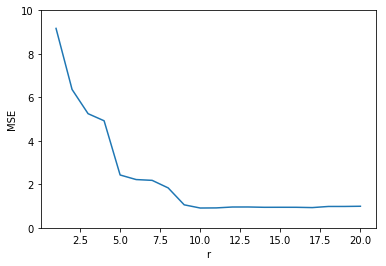

In [6]:
MSE=[]
for r in range(1,21):
    
    np.random.seed(5)
    X,y,X_test,y_test = gen_LR_data()
    #print(X.shape, y.shape, X_test.shape, y_test.shape) #checking

    reg = SingularValueRegressor(r=r)
    reg.fit(X,y)
    y_pred = reg.predict(X_test)
    MSE.append(metrics.mean_squared_error(y_test,y_pred))

plt.plot(np.arange(1,21),MSE)
plt.ylim(0,10)
plt.xlabel('r')
plt.ylabel('MSE')

__Exercise 4__ (30 pts)

The dataset in the hw1 directory has a Y variable, 7 predictor variables (X1 - X7).  Using sklearn and the class that you constructed above, compare ridge regression, OLS, kNN, and SVRegression.  Compare and tune the methods using appropriate testing procedures.  Comment on the tuning of each parameter in ridge, kNN, and SVRegression in markdown.  Be sure to standardize the X variables first and decide how to deal with NAs.  

In [7]:
import pandas as pd
import numpy as np
from sklearn import model_selection, linear_model, neighbors, preprocessing, metrics
import matplotlib.pyplot as plt

In [8]:
data_mat = pd.read_csv('hw1_data.csv')
data_mat.head()


,Y,X1,X2,X3,X4,X5,X6,X7
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


In [9]:
print(data_mat.shape)

#nan?
#print('NAN values: ',data_mat.isna().sum())

#deal with NAN values: fill them with the average of the column
data_mat = data_mat.fillna(np.round(data_mat.mean()))


y = data_mat['Y'].values
X = data_mat.drop(['Y'],axis=1).values

#standerdize x values
stand = preprocessing.StandardScaler()
stand.fit(X)

X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X,y,test_size = .33)

(398, 8)


In [10]:
#OLS
X_tr = np.hstack((np.ones((X_tr.shape[0],1)),X_tr)) #add intercept
X_te = np.hstack((np.ones((X_te.shape[0],1)),X_te)) #add intercept

lr = linear_model.LinearRegression(fit_intercept=True)
lr.fit(X_tr,y_tr)
y_pred = lr.predict(X_te)
MSE =  metrics.mean_squared_error(y_te,y_pred)
MSE

10.94313300688722

In [11]:
#Remove the added intercept for other models
X_tr = X_tr[:,1:]
X_te = X_te[:,1:]

Text(0, 0.5, 'MSE')

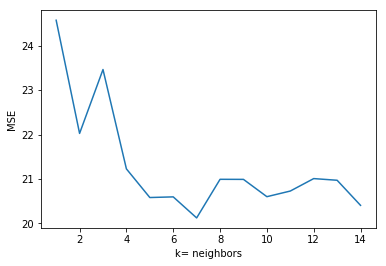

In [12]:
# KNN
## Fit K neighbors regression
MSE=[]
k=np.arange(1,15)
for i in k:
    
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_tr,y_tr)
    y_pred = knn.predict(X_te)
    MSE.append(metrics.mean_squared_error(y_te,y_pred))
#plot    
plt.plot(k,MSE)
#plt.ylim(0,50)
plt.xlabel('k= neighbors')
plt.ylabel('MSE')

tuned k =7

Text(0, 0.5, 'MSE')

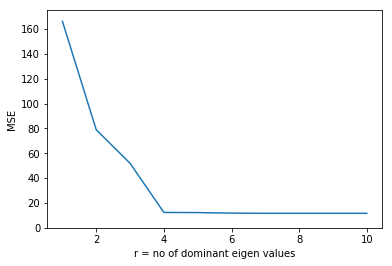

In [13]:
## SVregression
MSE=[]
r=np.arange(1,11)
for i in r:
    reg = SingularValueRegressor(r=i)
    reg.fit(X_tr,y_tr)
    y_pred = reg.predict(X_te)
    MSE.append(metrics.mean_squared_error(y_te,y_pred))

#plot
plt.plot(r,MSE)
plt.ylim(0,175)
plt.xlabel('r = no of dominant eigen values')
plt.ylabel('MSE')

In [ ]:
tuned r=4

10.943133006887226

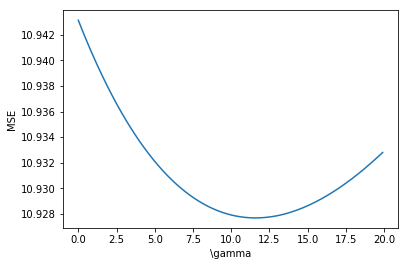

In [14]:
#Ridge regression
MSErr=[]
alpha=np.arange(0,20,0.1)
for i in alpha:
    rr = linear_model.Ridge(alpha=i,fit_intercept=True)
    rr.fit(X_tr,y_tr)
    y_pred = rr.predict(X_te)
    MSErr.append(metrics.mean_squared_error(y_te,y_pred))
    
#plot
plt.plot(alpha,MSErr)
#plt.ylim(0,50)
plt.xlabel('\gamma')
plt.ylabel('MSE')
MSErr[0]# This is exactly same as OLS loss

In [16]:
print('tuned gamma = ',alpha[np.argmin(MSErr)])

tuned gamma =  11.600000000000001
